In [1]:
import os
import mlflow
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
import numpy as np
import pandas as pd
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")
import argparse

In [2]:
dataset_name = "flowers102"
graph_type = "accuracy"

In [3]:
def get_color(value):
    if value > 0.5:
        return "white"
    else:
        return "black"

In [7]:
# mlflow.set_tracking_uri(uri="/Users/chengjiaying/scikit-activeml/tutorials/tracking")
mlflow.set_tracking_uri(uri="file:///mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking")

experiment = mlflow.get_experiment_by_name("Evaluation-Active-Learning-Params")
df = mlflow.search_runs(experiment_ids=experiment.experiment_id, output_format="pandas")

df = df[['params.dataset', 'params.qs', 'params.batch_size', 'params.n_cycles', 'params.seed', 'artifact_uri']]

query_stragies = df['params.qs'].unique()

Traceback (most recent call last):
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 882, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 694, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/uti

['Badge' 'TypiClust' 'CoreSet' 'DiscriminativeAL' 'UncertaintySampling'
 'RandomSampling']


In [11]:
def get_heat_map_np(df, dataset_name):
    df = df.loc[df['params.dataset'] == dataset_name]
    result_dict = {}
    
    for idx, qs_name in enumerate(query_stragies):
        df_qs = df.loc[df['params.qs'] == qs_name]
        r = []
        for idx_ti, row in df_qs.iterrows():
            artifact = os.path.join(row.artifact_uri, 'result.csv')
            artifact = artifact.split("file://")[1]
            if os.path.exists(artifact):
                result_qs = pd.read_csv(artifact, index_col=0)
                r.append(result_qs)
        results = pd.concat(r)
        result = results.groupby(['step'])[graph_type].agg(['mean', 'std']).set_axis(['mean', 'std'], axis=1)
        result_mean = result['mean'].to_numpy()
        result_dict[idx] = result_mean
        heat_map_numpy = np.zeros(shape=(6,6))
        
    for i in range(6):
        for j in range(6):
            if i == j:
                continue
            win_counter = 0
            i_algo_result = result_dict[i]
            j_algo_result = result_dict[j]
            for l in range(len(i_algo_result)):
                if i_algo_result[l] > j_algo_result[l]:
                    win_counter += 1
            heat_map_numpy[i, j] = win_counter / (len(i_algo_result))
    return heat_map_numpy

In [13]:
cifar10 = get_heat_map_np(df, "cifar10")
cifar100 = get_heat_map_np(df, "cifar100")
flowers102 = get_heat_map_np(df, "flowers102")
stl10 = get_heat_map_np(df, "stl10")

In [16]:
print(cifar10)

[[0.         0.45       0.85       0.93333333 1.         0.96666667]
 [0.55       0.         1.         1.         1.         1.        ]
 [0.15       0.         0.         0.23333333 0.51666667 0.31666667]
 [0.06666667 0.         0.76666667 0.         0.98333333 0.61666667]
 [0.         0.         0.46666667 0.01666667 0.         0.25      ]
 [0.03333333 0.         0.68333333 0.38333333 0.75       0.        ]]


In [14]:
heat_map = (cifar10 + cifar100 + flowers102 + stl10) / 4
print(heat_map)

[[0.         0.6375     0.77916667 0.91666667 0.75       0.96666667]
 [0.3625     0.         0.73333333 0.675      0.69166667 0.975     ]
 [0.22083333 0.25833333 0.         0.3        0.34583333 0.5375    ]
 [0.075      0.325      0.69166667 0.         0.62916667 0.8125    ]
 [0.21666667 0.30833333 0.61666667 0.37083333 0.         0.52916667]
 [0.03333333 0.025      0.4625     0.17083333 0.47083333 0.        ]]


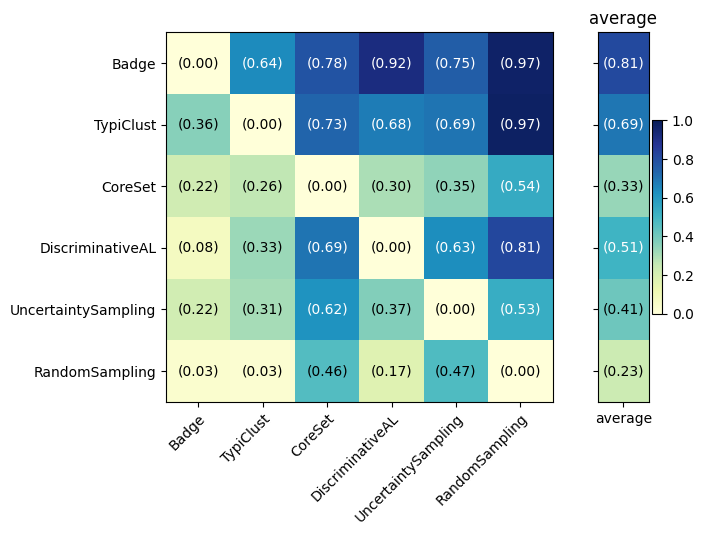

In [20]:
heat_map_sum = np.sum(heat_map, axis=1).reshape(-1, 1) / 5

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [6,1]})
a1 = axs[0].imshow(heat_map, cmap="YlGnBu",
                   vmin=0.0, vmax=1.0, aspect='auto',
                   interpolation='nearest')
a2 = axs[1].imshow(heat_map_sum, cmap="YlGnBu",
                   vmin=0.0, vmax=1.0, aspect='auto',
                   interpolation='nearest')

axs[0].set_xticks(np.arange(len(query_stragies)), labels=query_stragies)
plt.setp(axs[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
axs[0].set_yticks(np.arange(len(query_stragies)), labels=query_stragies)

axs[1].set_yticks(np.arange(len(query_stragies)), labels=query_stragies)
axs[1].set_xticks(np.arange(1), ['average'])

plt.colorbar(a2)

for i in range(6):
    for j in range(6):
        text = axs[0].text(j, i, f"({heat_map[i, j]:.2f})",
                       ha="center", va="center", color=get_color(heat_map[i, j]))

for i in range(6):
    text1 = axs[1].text(0, i, f"({heat_map_sum[i, 0]:.2f})",
                   ha="center", va="center", color=get_color(heat_map_sum[i, 0]))

plt.title('average', loc="center")

output_path = f'/mnt/stud/home/jcheng/scikit-activeml/tutorials/result_param/average_heatmap.pdf'
plt.savefig(output_path, bbox_inches="tight")